<a href="https://colab.research.google.com/github/MindLab-DP/WSI-Manipulation/blob/main/WSI_Manipulation_with_OpenSlide_and_Scikit_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WSI Manipulation with Openslide and Scikit-Image

This notebook contains some basic examples of WSI manipulation with Python, using the two libraries mentioned above.

* Author: Sebastian Medina

* MindLab, Universidad Nacional de Colombia


---

For this example notebook we are using the PANDA dataset, available [here]( https://www.kaggle.com/c/prostate-cancer-grade-assessment/data), take into account that the data used in this notebook is accessed from Google Drive.




## OpenSlide

OpenSlide is a C library that provides a simple interface for reading whole-slide images, which are high-resolution images used in digital pathology. These images can occupy tens of gigabytes when uncompressed, and so cannot be easily read using standard tools or libraries, which are designed for images that can be comfortably uncompressed into RAM. Whole-slide images are typically multi-resolution; OpenSlide allows reading a small amount of image data at the resolution closest to a desired zoom level.

OpenSlide can read virtual slides in several formats:

* Aperio (.svs, .tif)
* Hamamatsu (.ndpi, .vms, .vmu)
* Leica (.scn)
* MIRAX (.mrxs)
* Philips (.tiff)
* Sakura (.svslide)
* Trestle (.tif)
* Ventana (.bif, .tif)
* Generic tiled TIFF (.tif)












### Installing Openslide in Colab

In [ ]:
!apt -q install -y openslide-tools
!pip -q install openslide-python

Reading package lists...
Building dependency tree...
Reading state information...
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
!pip install -q tifffile 
!pip install -q imagecodecs

#### Importing useful libraries and setting some variables up

In [ ]:
import os
import sys
import cv2
import openslide
import skimage.io
import numpy as np
import pandas as pd
import PIL.Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [96]:
data_dir = '/content/drive/My Drive/Datasets/PANDA'
df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = f'{data_dir}/train_images/'
mask_folder = f'{data_dir}/train_label_masks/'

### Displaying an image with OpenSlide

In [100]:
df = df.loc[df['data_provider'] == 'radboud']

In [101]:
df.head()

,image_id,data_provider,isup_grade,gleason_score
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
12,004dd32d9cd167d9cc31c13b704498af,radboud,1,3+3
15,0068d4c7529e34fd4c9da863ce01a161,radboud,3,4+3
17,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3
18,007433133235efc27a39f11df6940829,radboud,0,negative


#### Loading a WSI

In [102]:
slide = df.iloc[0]['image_id']
image = openslide.OpenSlide(os.path.join(image_folder, f'{slide}.tiff'))

In [103]:
image.dimensions

(5888, 25344)

#### Getting a Thumbnail image of the slide

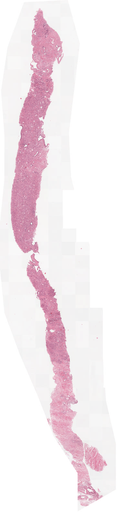

In [104]:
image.get_thumbnail((512,512))

#### Checking how many levels does the WSI have and their dimensions

In [105]:
image.level_count

3

In [106]:
image.level_dimensions

((5888, 25344), (1472, 6336), (368, 1584))

#### Reading a region of the slide

In [115]:
patch = image.read_region((1200, 1200),2,(256,256)) #read_region accepts: region, level and patch size

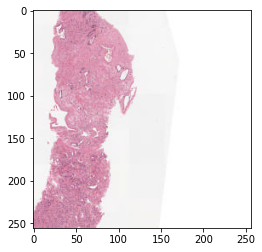

In [116]:
plt.imshow(patch)

### Reading segmentation masks

In [123]:
mask = openslide.OpenSlide(os.path.join(mask_folder, f'{slide}_mask.tiff'))
mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
cmap = mpl.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

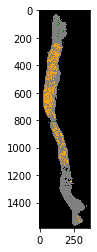

In [125]:
plt.imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) 

### Tiling with OpenSlide

In [128]:
from openslide.deepzoom import DeepZoomGenerator

In [129]:
tile_gen = DeepZoomGenerator(image, tile_size=254, overlap=1, limit_bounds=False)

In [130]:
tile_gen.level_tiles

((1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 2),
 (1, 4),
 (2, 7),
 (3, 13),
 (6, 25),
 (12, 50),
 (24, 100))

In [131]:
tile_gen.level_dimensions[10]

(184, 792)

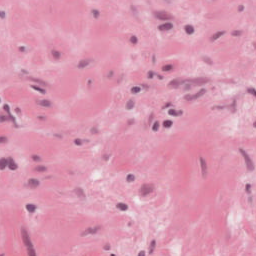

In [134]:
tile_gen.get_tile(15,(10,10))

## Scikit-Image

scikit-image builds on scipy.ndimage to provide a versatile set of image processing routines in Python.

#### Loading a WSI

In [135]:
wsi = skimage.io.MultiImage(os.path.join(image_folder, f'{slide}.tiff'))

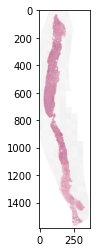

In [136]:
plt.imshow(wsi[2])

### To-Do: Tiling

### Segmentation masks

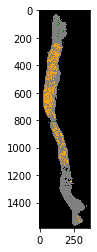

In [137]:
wsi_mask = skimage.io.MultiImage(os.path.join(mask_folder, f'{slide}_mask.tiff'))[2]
plt.imshow(wsi_mask[:,:,0], cmap=cmap, interpolation='nearest',vmin=0,vmax=5)

## To-Do: PyVips